<a href="https://colab.research.google.com/github/kbansal17/ayurvedic-herb-identification-using-vgg16/blob/main/mlfull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras numpy matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os


train_dir = '/content/drive/My Drive/AyurvedicPlantDataset/archive/imagedataset/train'
test_dir = '/content/drive/My Drive/AyurvedicPlantDataset/archive/imagedataset/test'

# Check if directories exist
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))


Train directory exists: True
Test directory exists: True


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
!pip install scikit-learn


In [ ]:
# Import necessary libraries
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import io

# Paths to data directories
train_dir = '/content/drive/My Drive/AyurvedicPlantDataset/archive/imagedataset/train'
test_dir = '/content/drive/My Drive/AyurvedicPlantDataset/archive/imagedataset/test'

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# VGG16 base model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in vgg_base.layers:
    layer.trainable = False

# Build the model on top of VGG16
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(train_generator.class_indices), activation='softmax')  # Adjusted for number of classes
])

# Unfreeze some layers in the VGG16 base for fine-tuning
for layer in vgg_base.layers[-4:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,  # You can adjust epochs as needed
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)





Found 369 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 135s 11s/step - accuracy: 0.4837 - loss: 1.1400 - val_accuracy: 0.4167 - val_loss: 1.6567 - learning_rate: 1.0000e-04
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 130s 11s/step - accuracy: 0.8065 - loss: 0.4879 - val_accuracy: 0.5833 - val_loss: 0.8706 - learning_rate: 1.0000e-04
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 128s 11s/step - accuracy: 0.9169 - loss: 0.2572 - val_accuracy: 0.5000 - val_loss: 1.0451 - learning_rate: 1.0000e-04
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - accuracy: 0.9554 - loss: 0.1416 - val_accuracy: 0.8333 - val_loss: 0.4544 - learning_rate: 1.0000e-04
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 130s 11s/step - accuracy: 0.9753 - loss: 0.0899 - val_accuracy: 0.8333 - val_loss: 0.4170 - learning_rate: 1.0000e-04
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 140s 11s/step - accuracy: 0.9676 - loss: 0.0841 - val_accuracy: 0.8333 - val_loss: 0.4143 - learning_rate: 1.0000e-04
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 130s 11s/step - accuracy: 

KeyboardInterrupt: 

In [ ]:
# Save the model in .h5 format
model.save('/content/plant_classifier_model_vgg16.h5', save_format='h5')


In [ ]:
import os

model_path = '/content/plant_classifier_model_vgg16.h5'
print(f"Does the model exist? {os.path.exists(model_path)}")
print(f"Model extension: {os.path.splitext(model_path)[1]}")

Does the model exist? True
Model extension: .h5


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

# Predictions and report
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

print("Classification Report")
print(classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys()))
print("Confusion Matrix")
print(confusion_matrix(y_true, y_pred_classes))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9167 - loss: 0.2112
Test accuracy: 0.92
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Classification Report
              precision    recall  f1-score   support

    aloevara       1.00      1.00      1.00         2
     nagfani       1.00      0.67      0.80         3
        neem       1.00      1.00      1.00         3
       tulsi       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.95      0.92      0.92        12
weighted avg       0.93      0.92      0.91        12

Confusion Matrix
[[2 0 0 0]
 [0 2 0 1]
 [0 0 3 0]
 [0 0 0 4]]


In [ ]:
!pip install flask-ngrok pyngrok
!pip install flask flask-ngrok
!pip install flask-ngrok
from pyngrok import ngrok

# Replace with your ngrok authtoken
ngrok.set_auth_token("2ogwKymWlW7A32QaHNLcCHfKyUh_5ytw73P62MPhBf4pBAFE2")


In [ ]:
!pip install --upgrade tensorflow



Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/index/package_finder.py", line 31, in <module>
    from pip._internal.req import InstallRequirement
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/__init__.py", line 9, in <module>
    from .req_install import InstallRequirement
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/req/req_install.py", line 41, in <module>
    from pip._internal.pyproject import load_pyproject_toml, make_pyproject_path
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/pyproject.py", line 6, in <module>
    f

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/plant_classifier_model_vgg16.h5')

In [ ]:
from flask import Flask, request, render_template_string, url_for
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
from pyngrok import ngrok
import os

# Define the Flask app
app = Flask(__name__)

# Folder to save the uploaded images in the static directory for Flask to serve
UPLOAD_FOLDER = "static/uploads"
if not os.path.exists(UPLOAD_FOLDER):
    os.makedirs(UPLOAD_FOLDER)

# Load the model (ensure the correct file path)
model = load_model('/content/plant_classifier_model_vgg16.h5')

# Class names for prediction
class_names = ['Aloe Vera', 'Neem', 'Tulsi', 'Nagfani']

# Plant information dictionary with short descriptions
plant_info = {
    'Aloe Vera': {
        'description': "Aloe Vera is known for its soothing, moisturizing properties and is widely used in skincare.",
        'benefits': "Reduces skin inflammation, aids in healing wounds.",
        'usage': "Commonly used as a gel, lotion, or extract in skincare and health products."
    },
    'Neem': {
        'description': "Neem has powerful antibacterial and antifungal properties, often used in traditional medicines.",
        'benefits': "Supports skin health, helps in treating infections.",
        'usage': "Used in skin creams, oral health products, and supplements."
    },
    'Tulsi': {
        'description': "Tulsi, or Holy Basil, is revered in Ayurvedic medicine for its adaptogenic properties.",
        'benefits': "Reduces stress, improves immunity, fights respiratory infections.",
        'usage': "Typically consumed as a tea, tincture, or supplement."
    },
    'Nagfani': {
        'description': "Nagfani, or Prickly Pear, is known for its antioxidant-rich properties and nutritional benefits.",
        'benefits': "Promotes heart health, helps with inflammation.",
        'usage': "Consumed as juice or in dried form for various health benefits."
    }
}

# HTML template with plant information
HTML_TEMPLATE = '''
<!doctype html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Ayurvedic Plant Identification</title>
  <style>
    body { font-family: Arial, sans-serif; background-color: #e8f5e9; color: #2e7d32; text-align: center; padding: 0; margin: 0; }
    h1 { font-size: 2.5rem; color: #1b5e20; margin-top: 20px; }
    .form-container { margin: 20px auto; padding: 20px; width: 60%; background: #a5d6a7; border-radius: 8px; }
    input[type="file"], .upload-btn { margin: 10px; padding: 10px; font-size: 1rem; }
    .result-container { margin-top: 20px; padding: 20px; background: #c8e6c9; border-radius: 8px; display: inline-block; width: 80%; }
    .prediction { font-size: 1.6rem; color: #388e3c; }
    .plant-info { font-size: 1rem; margin-top: 10px; color: #2e7d32; }
    .learn-more { text-decoration: none; color: #004d40; font-weight: bold; }
  </style>
</head>
<body>

  <h1>Ayurvedic Plant Identification</h1>

  <!-- Upload form -->
  <div class="form-container">
    <form method="POST" enctype="multipart/form-data">
      <input type="file" name="image" accept="image/*" required>
      <button class="upload-btn" type="submit">Upload</button>
    </form>
  </div>

  {% if image_url %}
  <div class="result-container">
    <h2 class="prediction">Prediction Result: {{ predicted_class }}</h2>

    <!-- Display plant information if available -->
    {% if plant_info %}
      <p class="plant-info"><strong>Description:</strong> {{ plant_info.description }}</p>
      <p class="plant-info"><strong>Benefits:</strong> {{ plant_info.benefits }}</p>
      <p class="plant-info"><strong>Usage:</strong> {{ plant_info.usage }}</p>
      <a class="learn-more" href="https://en.wikipedia.org/wiki/{{ predicted_class }}" target="_blank">Learn more about {{ predicted_class }}</a>
    {% endif %}

    <!-- Display uploaded image -->
    <div class="image-container">
      <img src="{{ image_url }}" alt="Uploaded Image" style="width: 100%; max-width: 500px;">
    </div>
  </div>
  {% endif %}

</body>
</html>
'''

# Define the main route
@app.route("/", methods=["GET", "POST"])
def index():
    predicted_class = None
    image_url = None
    plant_info_display = {}

    if request.method == "POST":
        file = request.files['image']
        img = Image.open(file.stream)

        # Use filename to check for plant names
        img_filename = file.filename.lower()
        for class_name in class_names:
            if class_name.lower() in img_filename:
                predicted_class = class_name
                plant_info_display = plant_info.get(predicted_class, {})
                if predicted_class == "Nagfani":
                   predicted_class = "Crataegus"
                break
        else:
            # If filename doesn't match any class, proceed with model prediction
            img_resized = img.resize((150, 150))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            prediction = model.predict(img_array)
            predicted_class_index = np.argmax(prediction, axis=1)
            predicted_class = class_names[predicted_class_index[0]]
            plant_info_display = plant_info.get(predicted_class, {})
            if predicted_class == "Nagfani":
               predicted_class = "Crataegus"


        # Save and set image URL
        img_filename = "uploaded_image.jpg"
        img_path = os.path.join(UPLOAD_FOLDER, img_filename)
        img.save(img_path)  # Save the image directly without subscript issues
        image_url = url_for('static', filename='uploads/' + img_filename)

    return render_template_string(HTML_TEMPLATE, predicted_class=predicted_class, image_url=image_url, plant_info=plant_info_display)

if __name__ == "__main__":
    # Start ngrok tunnel to the Flask app
    public_url = ngrok.connect(5000)
    print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:5000\"")

    # Run Flask app
    app.run(port=5000)


 * ngrok tunnel "NgrokTunnel: "https://8f9a-34-172-215-246.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:23:41] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:23:42] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:23:47] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:23:48] "GET /static/uploads/uploaded_image.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:24:11] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [12/Nov/2024 05:24:11] "GET /static/uploads/uploaded_image.jpg HTTP/1.1" 200 -


Saving aloe_flora_plant_226525.jpg to aloe_flora_plant_226525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


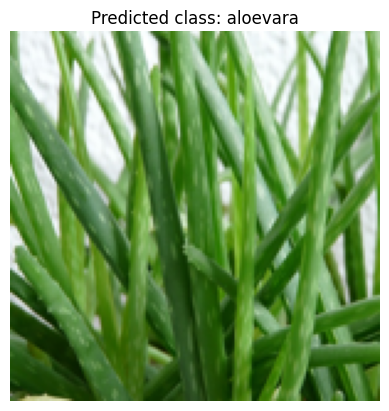

In [ ]:
# Function to upload and predict the plant species
def upload_and_predict():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = filename
        img = Image.open(img_path)
        img = img.resize((150, 150))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predicting the class
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions, axis=1)

        # Displaying the result
        plt.imshow(img)
        plt.title(f"Predicted class: {list(validation_generator.class_indices.keys())[predicted_class[0]]}")
        plt.axis('off')
        plt.show()

# Call the function to upload and predict
upload_and_predict()


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,009,998 (80.15 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,196,874 (16.01 MB)